# Week 3 Tutorial (Solutions) - Probability Review, Distribution Approximation and Divergences

### Authors: Rajit Rajpal, Kirill Tamogashev, Nikolay Malkin

We will aim to fit data using GMMs by optimizing Forward KL (zero-avoiding, mass-covering) and Reverse KL (zero-forcing, mode-seeking).
`# TODO` are for you to implement. Solutions will contain the completed code.

---

## 1. Introduction & Setup

In this tutorial, we will explore how to approximate a complex **Target** distribution (**P**) using a simpler **Model** distribution (**Q**). We will visualize why different divergence measures (Forward KL, Reverse KL) lead to different approximations.

### The Setup

- **Target (P):** A fixed Gaussian Mixture Model (GMM) with 4 components.
- **Model (Q\_θ):** A learnable GMM. We will try to learn the parameters θ (means, covariances, weights).

### 1.1 Imports and Data

First, let's define our ground truth data parameters.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as D

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- The Target Distribution P(x) ---
# We define a GMM with 4 components
means_data = torch.tensor([[0.5,0], [3,2], [-1,1], [2,-1]]) * 2
covs_data = torch.tensor([[[1,0],[0,1]], [[1,0.5],[0.5,1]], [[1,-0.5],[-0.5,1]], [[0.5,0],[0,4]]])
covs_data[1] *= 1
weights_data = torch.tensor([0.2, 0.3, 0.2, 0.3])

print("Target defined with 4 components.")

Target defined with 4 components.


## 2. The Computational Graph: Sampling and Density

To perform computations, we need two fundamental operations for our GMM:

- **Sampling:**  
  $$ x \sim P(x) $$

- **Density Evaluation:**  
  $$ p(x) $$

### Exercise 1: Implement GMM Density

The probability density of a GMM is the weighted sum of its component densities:

$$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

Complete the function below.

---

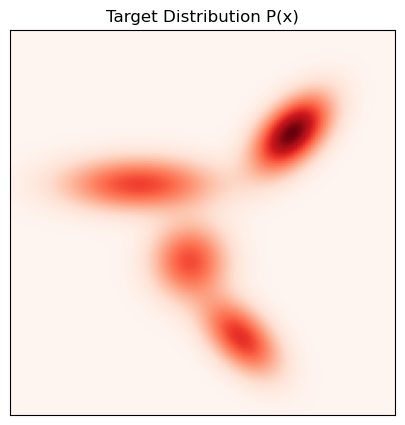

In [2]:
def gmm_sample(means, covs, weights, n):
    """
    Samples n points from a GMM.
    """
    n = int(n)
    # 1. Sample component indices according to weights (Categorical)
    indices = torch.multinomial(weights, n, replacement=True)
    
    # 2. Sample from the specific Gaussian components
    # (Here we sample from all and select, effective for batching)
    samples = torch.zeros((n, 2))
    for i in range(len(means)):
        # Create a batch of samples for this component
        # We use numpy for standard sampling here, but torch.distributions is also valid
        comp_samples = np.random.multivariate_normal(means[i].detach().numpy(), covs[i].detach().numpy(), n)
        samples[indices == i] = torch.from_numpy(comp_samples[indices == i]).float()
    return samples

def gmm_density(X, means=means_data, covs=covs_data, weights=weights_data):
    """
    Computes p(x) for a batch of points X.
    """
    # X shape: (Batch, 2)
    density = torch.zeros(X.shape[0])
    
    for i in range(len(means)):
        # TODO: Calculate the multivariate gaussian density for component i
        # Hint: You can use the formula:
        # exp(-0.5 * (x-mu)^T Sigma^-1 (x-mu)) / sqrt((2pi)^k |Sigma|)
        
        diff = X - means[i]
        # Calculate Mahalanobis distance term
        inv_cov = torch.linalg.inv(covs[i])
        exponent = -0.5 * torch.sum(diff @ inv_cov * diff, axis=1) # This will be TODO.
        
        # Calculate Normalization constant
        norm_const = torch.sqrt((2 * np.pi)**2 * torch.det(covs[i])) # This will be TODO, use torch.det()
        
        # Add weighted probability to total density
        prob_i = torch.exp(exponent) / norm_const
        density += weights[i] * prob_i
        
    return density

# --- Visualization Code (Do not modify) ---
def plot_density(means, covs, weights, title="Density"):
    XX, YY = torch.meshgrid(torch.linspace(-5, 10, 150), torch.linspace(-7, 8, 150), indexing='xy')
    grid_x = torch.stack([XX.reshape(-1), YY.reshape(-1)], dim=1)
    d = gmm_density(grid_x, means, covs, weights).reshape(150, 150)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(d.T, extent=(-5, 10, -7, 8), origin='lower', cmap='Reds')
    plt.title(title)
    plt.xlim(-5, 10); plt.ylim(-7, 8)
    plt.xticks([]); plt.yticks([])
    plt.show()

plot_density(means_data, covs_data, weights_data, "Target Distribution P(x)")

## 3. Monte Carlo Estimation

We often cannot calculate integrals like entropy

$$
H(P) = -\int p(x)\log p(x)\,dx = \mathbb{E}_{x \sim P}[\log p(x)]
$$

analytically. 

Instead, we use Monte Carlo estimation:

$$
\mathbb{E}_{x \sim P}[f(x)] \approx \frac{1}{N}\sum_{i=1}^{N} f(x_i)
\quad \text{where } x_i \sim P(x)
$$

### Exercise 2: Estimate KL Divergence

We need to measure the distance between two distributions. The **Forward KL** is defined as:

$$
D_{\mathrm{KL}}(P \| Q) = \mathbb{E}_{x \sim P}[\log \frac{P(x)}{Q(x)}]
$$

Implement the estimator below.



In [3]:
def estimate_kl_forward(means_p, covs_p, weights_p, means_q, covs_q, weights_q, n_samples=1000):
    """
    Estimates KL(P || Q) using samples from P.
    """
    with torch.no_grad():
        # 1. Sample from P
        samples = gmm_sample(means_p, covs_p, weights_p, n_samples)
        
        # 2. Evaluate densities
        p_density = gmm_density(samples, means_p, covs_p, weights_p)
        q_density = gmm_density(samples, means_q, covs_q, weights_q)
        
        # 3. Compute Monte Carlo Estimator
        # TODO: Return the mean difference of log densities, you can use torch.mean()
        kl = torch.mean(torch.log(p_density) - torch.log(q_density))
        
    return kl.item()

# Test with P against itself (Should be approx 0)
print(f"KL(P||P) approx: {estimate_kl_forward(means_data, covs_data, weights_data, means_data, covs_data, weights_data):.5f}")

KL(P||P) approx: 0.00000


## 4. Optimization: Fitting the Model

Now we will define a learnable model $ Q_\theta $. We will parameterize the covariance using a factorization

$$
\Sigma = A A^{T}
$$

to ensure it remains positive semi-definite (Cholesky decomposition).

The parameters of the GMM are: $$\theta = (\mu_k, \Sigma_k, w_k)$$ for $k \in \{1,..,n\}$.

### Exercise 3: Forward KL (MLE)

**Objective:** Minimize

$$
D_{\mathrm{KL}}(P \| Q_\theta)
$$

$$
\mathcal{L}_{\mathrm{FKL}} = \mathbb{E}_{x \sim P}[\log P(x) - \log Q_\theta(x)]
$$

Since $$ \mathbb{E}_{x \sim P}[\log P(x)] $$ is constant with respect to θ, minimizing Forward KL is equivalent to **Maximizing Likelihood (MLE)**:

$$
\mathcal{L} \approx -\frac{1}{N}\sum_{i=1}^{N} \log Q_\theta(x_i)
\quad \text{where } x_i \sim P_{\text{data}}
$$
##### Remember that maximizing log-likelihood is equivalent to minimizing negative log-likelihood (NLL) which is more suitable as a loss to minimize. Therefore, the function below will return the NLL.
---

In [4]:
def compute_fkl(means_m, covs_m, weights_m, means_t, covs_t, weights_t, n_samples=500):
    """ Minimize KL(P || Q) -> Maximize E_p[log Q] """
    # 1. Sample from Target P (fixed)
    x_p = gmm_sample(means_t, covs_t, weights_t, n_samples)
    
    # 2. Evaluate Model probability Q on these samples
    q_on_p = gmm_density(x_p, means_m, covs_m, weights_m)
    
    # 3. TODO: Loss = Negative Log Likelihood. Add 1e-10 to avoid log(0) error.
    loss = -torch.mean(torch.log(q_on_p + 1e-10))
    return loss

# Test with P against itself (Should be approx 4-4.5)
print(f"NLL approx: {compute_fkl(means_data, covs_data, weights_data, means_data, covs_data, weights_data):.5f}")

NLL approx: 4.11217


### Exercise 4: Reverse KL (Mode Seeking)

**Objective:** Minimize

$$
D_{\mathrm{KL}}(Q_\theta \| P)
$$

$$
\mathcal{L}_{\mathrm{RKL}} = \mathbb{E}_{x \sim Q_\theta}
[\log Q_\theta(x) - \log P(x)]
$$

The issue with this is that $\nabla_{\theta} \mathcal{L}(\theta)$ cannot be computed directly using standard backpropagation because the expectation is taken over samples $x$ drawn from $Q_{\theta}$, and the sampling operation is non-differentiable. To overcome this, we use the Score Function Estimator (often called REINFORCE in reinforcement learning). We rely on the "Log-Derivative Trick" identity: $$\nabla_{\theta} Q_{\theta}(x) = Q_{\theta}(x)\nabla_{\theta} \log Q_{\theta}(x)$$.

Applying this to the gradient of the expectation: $$\nabla_{\theta} \mathcal{L}(\theta) = \mathbb{E}_{x \sim Q_{\theta}}[
\underbrace{\big(\log Q_{\theta}(x) - \log P(x)\big)}_{\text{score/reward}}\;\cdot\;\nabla_{\theta} \log Q_{\theta}(x)]$$

You may use a Monte-Carlo expectation to approximate the above expectation. Note that this is widely known to be quite high-variance and unstable.

In [5]:
def compute_rkl(means_m, covs_m, weights_m, means_t, covs_t, weights_t, n_samples=500):
    """ Minimize KL(Q || P)"""
    # 1. Sample from Model Q (No grad for sampling location in this simple setup)
    with torch.no_grad():
        x_q = gmm_sample(means_m, covs_m, weights_m, n_samples)
    
    # 2. Evaluate densities
    q_x = gmm_density(x_q, means_m, covs_m, weights_m)
    p_x = gmm_density(x_q, means_t, covs_t, weights_t)
    
    # 3. Compute Loss
    # We use the identity: grad(E_q[f]) = E_q[f * grad(log q)]
    # Here f = log q - log p
    log_q = torch.log(q_x + 1e-10)
    log_p = torch.log(p_x + 1e-10)
    
    # The term in brackets is the "reward/score", we detach it so it's treated as a constant scalar
    score = (log_q - log_p).detach() # TODO: Implement the score/reward.
    loss = (score * log_q).mean() # TODO: Implement the loss using the score defined above.
    return loss

# Test with P against itself (Should be approx 0)
print(f"Loss approx: {compute_rkl(means_data, covs_data, weights_data, means_data, covs_data, weights_data):.5f}")

Loss approx: 0.00000


## Time to get training!
This will fit the GMM using 1-4 components for forward KL and reverse KL. Nothing to implement here, just run it! It should take upto a minute to train each objective.

--- Running Experiments: Forward KL (MLE) ---


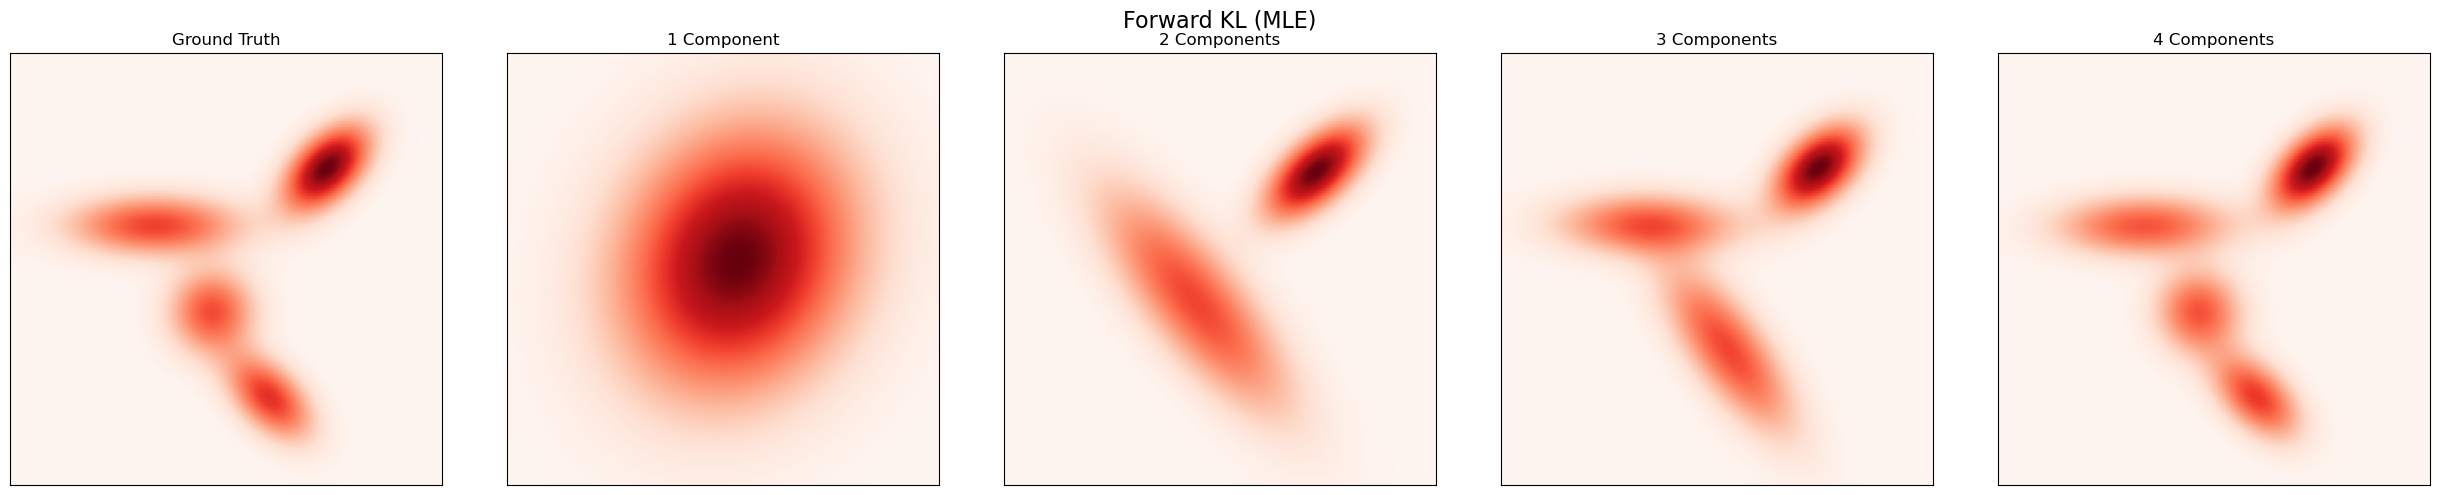

--- Running Experiments: Reverse KL (Mode Seeking) ---


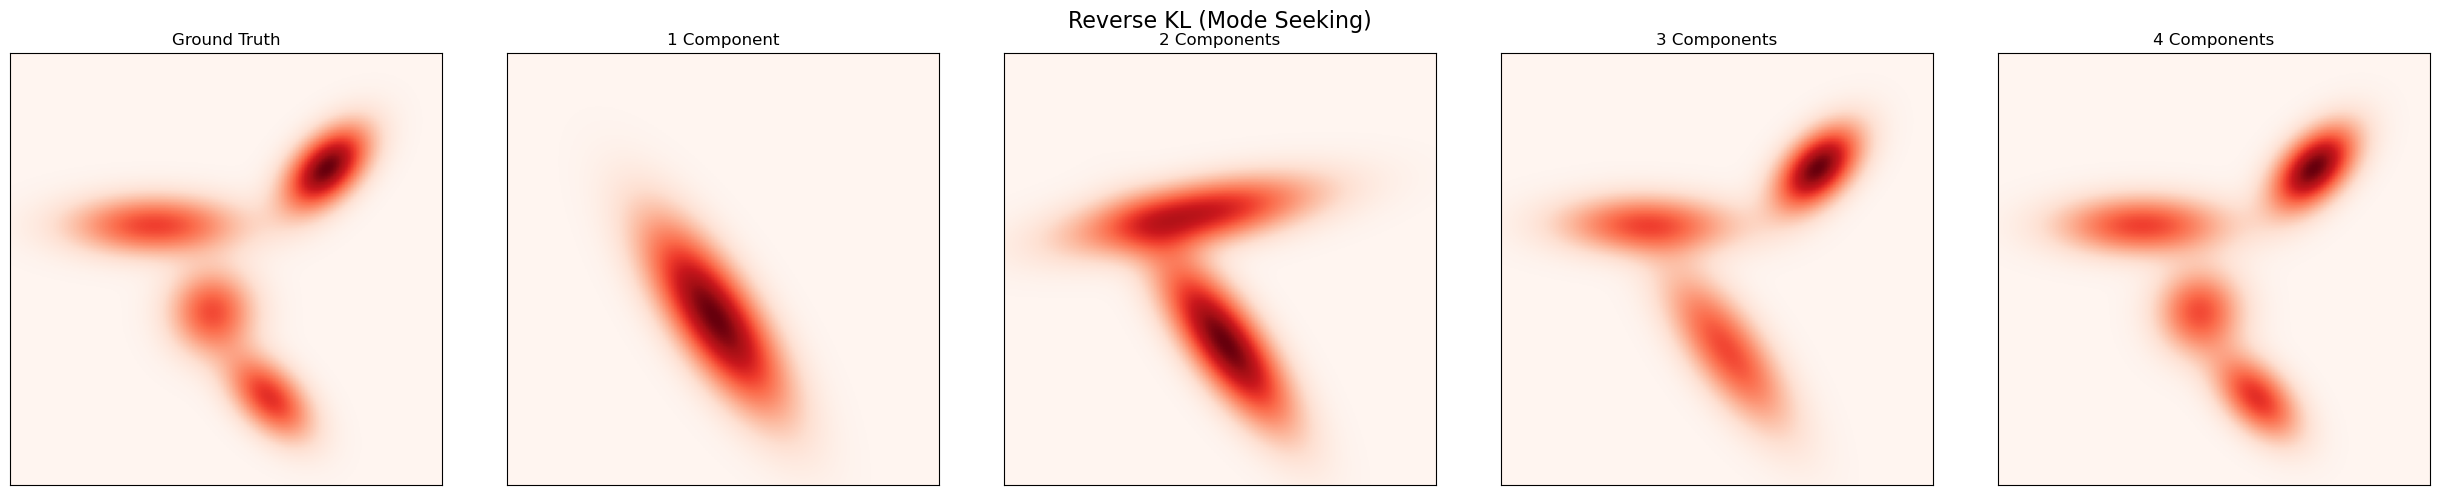

In [6]:
import torch
import matplotlib.pyplot as plt

# --- Training Helper (Returns parameters instead of plotting) ---
def train_gmm_parameters(loss_fn, n_comps, iterations=5000):
    # Initialize Parameters
    means_model = torch.randn((n_comps, 2), requires_grad=True)
    sqcovs_model = torch.stack([torch.eye(2) for _ in range(n_comps)])
    sqcovs_model.requires_grad_(True)
    weights_logits = torch.zeros(n_comps, requires_grad=True)

    opt = torch.optim.Adam([means_model, sqcovs_model, weights_logits], lr=0.01)
    
    for it in range(iterations):
        current_covs = sqcovs_model @ sqcovs_model.transpose(-1, -2)
        current_weights = torch.softmax(weights_logits, dim=0)
        
        # Accessing global data variables (means_data, covs_data, weights_data)
        loss = loss_fn(means_model, current_covs, current_weights, 
                       means_data, covs_data, weights_data)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
    final_covs = sqcovs_model @ sqcovs_model.transpose(-1, -2)
    final_weights = torch.softmax(weights_logits, dim=0)
    
    return means_model.detach(), final_covs.detach(), final_weights.detach()

# --- Experiment Runner (Ground Truth + Optimize 1-4) ---
def run_experiment_row(loss_fn, title_prefix):
    print(f"--- Running Experiments: {title_prefix} ---")
    
    # 1. Train models for n=1 to 4
    results = []
    component_counts = [1, 2, 3, 4]
    
    for n in component_counts:
        params = train_gmm_parameters(loss_fn, n_comps=n)
        results.append(params)

    # 2. Visualization (1 Row, 5 Cols: GT + 4 Results)
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(f"{title_prefix}", fontsize=16)

    # Common Grid Generation
    with torch.no_grad():
        XX, YY = torch.meshgrid(torch.linspace(-5, 10, 150), torch.linspace(-7, 8, 150), indexing='xy')
        grid_x = torch.stack([XX.reshape(-1), YY.reshape(-1)], dim=1)
        
        # --- Column 1: Ground Truth ---
        d_gt = gmm_density(grid_x, means_data, covs_data, weights_data).reshape(150, 150)
        axes[0].imshow(d_gt.T, extent=(-5, 10, -7, 8), origin='lower', cmap='Reds')
        axes[0].set_title("Ground Truth")
        axes[0].set_xlim(-5, 10); axes[0].set_ylim(-7, 8)
        axes[0].set_xticks([]); axes[0].set_yticks([])

        # --- Columns 2-5: Optimization Results ---
        for i, (n, (means, covs, weights)) in enumerate(zip(component_counts, results)):
            ax = axes[i + 1] # Shift index right by 1 to make room for GT
            
            # Compute density
            d = gmm_density(grid_x, means, covs, weights).reshape(150, 150)
            
            # Plot
            ax.imshow(d.T, extent=(-5, 10, -7, 8), origin='lower', cmap='Reds')
            ax.set_title(f"{n} Component{'s' if n > 1 else ''}")
            ax.set_xlim(-5, 10); ax.set_ylim(-7, 8)
            ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# --- Run Experiments ---
run_experiment_row(compute_fkl, "Forward KL (MLE)")
run_experiment_row(compute_rkl, "Reverse KL (Mode Seeking)")

## 5. Discussion Questions

**Forward KL (MLE):**  
Look at the result of `fkl`. Does the model distribution cover all 4 components of the target? Why does it create *bridges* of probability density between the modes?

*Hint:* What is the penalty for $ Q(x) \approx 0 $ where $ P(x) > 0 $?

**Reverse KL:**  
Look at the result of `rkl`. Why does it collapse to a single mode?

*Hint:* What happens if $ Q(x) $ is wide and covers areas where $ P(x) \approx 0 $?

Answer: 